# Spectra Visualization

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import plotly.io as pio
from plotly.subplots import make_subplots

from htc.settings_seg import settings_seg
from htc.tivita.hsi import tivita_wavelengths
from htc.utils.helper_functions import group_median_spectra, median_table
from htc.utils.visualization import add_std_fill

pio.kaleido.scope.mathjax = None

[WARNING][htc] The environment variable PATH_Tivita_multiorgan_human was set to /mnt/nvme_4tb/test2    Datasets.py:112
and the path exists, but the data folder data does not exist. Did you set a wrong data_folder_name?                     

[WARNING][htc] The environment variable PATH_Tivita_sepsis_study was set to /mnt/nvme_4tb/test and the Datasets.py:112
path exists, but the data folder data does not exist. Did you set a wrong data_folder_name?                             

In [2]:
df = median_table(dataset_name="2021_02_05_Tivita_multiorgan_semantic")

# Rename the raw label names to the paper label names (this e.g. maps multiple labels to the background)
mapping = settings_seg.label_mapping
df["label_name"] = [mapping.index_to_name(mapping.name_to_index(l)) for l in df["label_name"]]
labels = [l for l in settings_seg.label_colors_paper.keys() if l in mapping.label_names() and l != "background"]
df = df.query("label_name in @labels")

df = group_median_spectra(df)
df.head()

,subject_name,label_name,median_spectrum,std_spectrum,median_normalized_spectrum,std_normalized_spectrum
0,P041,stomach,"[0.12675586, 0.12330504, 0.12617046, 0.1209757...","[0.06587903, 0.058881517, 0.054719396, 0.05184...","[0.0043628626, 0.004263814, 0.0043737767, 0.00...","[0.0018820902, 0.0015163, 0.0012513382, 0.0010..."
1,P041,small_bowel,"[0.087310895, 0.076581284, 0.07790566, 0.07069...","[0.058016002, 0.051022634, 0.046935044, 0.0448...","[0.0032885077, 0.0029193577, 0.002989222, 0.00...","[0.001960174, 0.001583002, 0.0013138019, 0.001..."
2,P041,colon,"[0.10315986, 0.09310691, 0.094236344, 0.086908...","[0.07545744, 0.06545968, 0.059809253, 0.055945...","[0.0044584717, 0.004038328, 0.0040940363, 0.00...","[0.0026651672, 0.0020718586, 0.0016558219, 0.0..."
3,P041,liver,"[0.03191203, 0.021551395, 0.0244628, 0.0198486...","[0.112921305, 0.111873075, 0.11433938, 0.11716...","[0.0024635612, 0.0016590182, 0.0019006822, 0.0...","[0.0036868192, 0.0029232297, 0.0024511062, 0.0..."
4,P041,spleen,"[0.052368417, 0.039222986, 0.03931353, 0.03355...","[0.056844406, 0.0489759, 0.04456355, 0.0413927...","[0.0045814407, 0.0034805448, 0.0035667056, 0.0...","[0.0044883583, 0.0034886408, 0.0027725827, 0.0..."


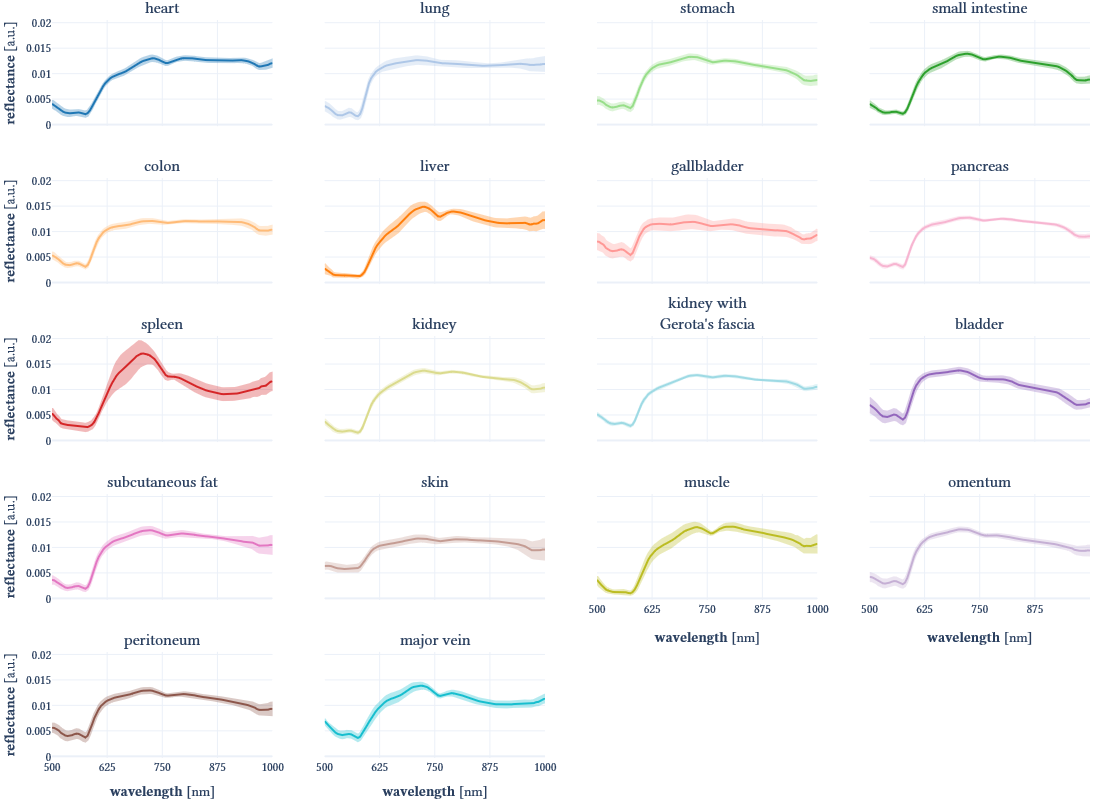

In [3]:
n_rows = 5
n_cols = 4
label_colors = settings_seg.label_colors_paper
label_colors["background"] = "#CCCCCC"
label_names = [settings_seg.labels_paper_renaming.get(label, label) for label in labels]
fig = make_subplots(
    rows=n_rows, cols=n_cols, shared_xaxes="all", shared_yaxes="all", subplot_titles=label_names, vertical_spacing=0.07
)

for i, label in enumerate(labels):
    df_label = df.query("label_name == @label")
    row = i // n_cols
    col = i % n_cols

    spec = np.stack(df_label["median_normalized_spectrum"])  # Spectra from all pigs
    spec_mean = np.mean(spec, axis=0)
    spec_std = np.std(spec, axis=0)

    name = settings_seg.labels_paper_renaming.get(label, label)
    fig = add_std_fill(
        fig,
        spec_mean,
        spec_std,
        x=tivita_wavelengths(),
        linecolor=label_colors[label],
        label=name,
        showlegend=False,
        row=row + 1,
        col=col + 1,
    )

    if row == n_rows - 1:
        fig.update_xaxes(title_text="<b>wavelength</b> [nm]", row=row + 1, col=col + 1)
    if col == 0:
        fig.update_yaxes(title_text="<b>reflectance</b> [a.u.]", row=row + 1, col=col + 1)

    if col >= n_cols - 2 and row == n_rows - 2:
        fig.update_xaxes(showticklabels=True, row=row + 1, col=col + 1)
        fig.update_xaxes(title_text="<b>wavelength</b> [nm]", row=row + 1, col=col + 1)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=20))
fig.update_xaxes(tick0=500, dtick=125)
fig.update_layout(height=800, width=900)
fig.update_layout(template="plotly_white", font_family="Libertinus Serif", font_size=12)
fig.write_image(settings_seg.paper_dir / "spectra.pdf")
fig.show()